In [1]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
print "Tensorflow Version:", tf.__version__

Tensorflow Version: 2.0.0


In [2]:
# Build zipcode to income dictionary
zip_inc = pd.read_excel('zip_to_income.xlsx', header=None)

zipList = zip_inc[0].get_values().tolist()
incList = zip_inc[1].get_values().tolist()

zip_to_income = dict()
for i,j in zip(zipList, incList):
    zip_to_income[i] = j

In [3]:
# Read data
data = pd.read_excel('resd_data_1.xlsx', header=None).values

In [4]:
# Data Filtering
badIndex = []
cols = data.shape[1]

# Change Zip Code to Avg. Income 
# Remove invalid Zip Code's
for count, zipCode in enumerate(data[:, cols - 2]):
    if zipCode in zip_to_income.keys():
        data[count, cols - 2] = zip_to_income[zipCode]
    else:
        badIndex.append(count)
    
# Delete and reset bad index
# Update columns count
data = np.delete(data, badIndex, 0)
badIndex = []

# Remove entries with with no listed price (<= 1000)
for count, price in enumerate(data[:, cols - 1]):
    if price <= 1000:
        badIndex.append(count)
    
# Delete and reset bad index
# Update columns count
data = np.delete(data, badIndex, 0)
badIndex = []


# Remove entries which are out of margin
for count, (sqft, lotsqft, year, beds, baths, stories, income) in enumerate(zip(data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5], data[:, 6])):
      
    if sqft < 1000 or sqft > 10000:
        badIndex.append(count)
    elif lotsqft < 0 or lotsqft > 50000:
        badIndex.append(count)
    elif year < 1940:
        badIndex.append(count)
    elif beds < 1 or beds > 5:
        badIndex.append(count)
    elif baths < 1 or baths > 6:
        badIndex.append(count)
    elif stories > 3: 
        badIndex.append(count)
    elif income > 120000:
        badIndex.append(count)
        
# Delete and reset bad index
# Update columns count
# train_data = np.delete(train_data, badIndex, 0)
# train_targets = np.delete(train_targets, badIndex, 0)
data = np.delete(data, badIndex, 0)
badIndex = []

In [5]:
# Split Data
n_train = int(0.9 * data.shape[0])
(train_data, train_targets) = data[0:n_train, 0:cols - 1], data[0:n_train, cols - 1]
(test_data,  test_targets)  = data[n_train::, 0:cols - 1], data[n_train::, cols - 1]

In [6]:
train_data.shape

(5795, 7)

In [7]:
test_data.shape

(644, 7)

In [16]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data = train_data - mean
test_data  = test_data - mean

std = train_data.std(axis=0)
train_data /= std
test_data /= std

In [17]:
# Building the model network
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [18]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 200
num_batch = 16
all_mae_histories_val = []
all_mae_histories_train = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=num_batch, verbose=0)
    mae_history_val = history.history['val_mae']
    mae_history_train = history.history['mae']
    all_mae_histories_val.append(mae_history_val)
    all_mae_histories_train.append(mae_history_train)
    
# Plot validation MAE    
average_mae_history_val = [np.mean([x[i] for x in all_mae_histories_val]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history_val) + 1), average_mae_history_val)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Test model
model = build_model()
model.fit(train_data, train_targets, epochs=100, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print("Test MAE: ", test_mae_score)

644/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

('Test MAE: ', 363947.72)


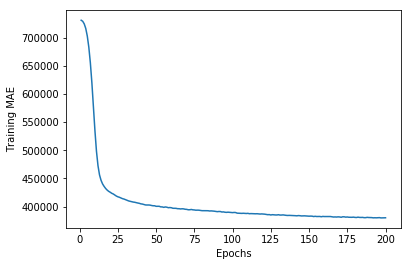

In [10]:
# Plot training MAE 
average_mae_history_train = [np.mean([x[i] for x in all_mae_histories_train]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history_train) + 1), average_mae_history_train)
plt.xlabel('Epochs')
plt.ylabel('Training MAE')
plt.show()